<span style="color:blue; font-weight:bold; font-size:24px;">Visecral Leishmansis Hyper Tuning Models</span>

In [107]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV
!pip install xgboost
!pip install shap

In [108]:
# Loading the dataset
file_path = 'C:/Users/mnzilani/VL Machine Learning/Turkana_LagsF (1).xlsx'
lags = pd.read_excel(file_path, sheet_name=None)

In [109]:
#Looking at the data types
lags["L2"].dtypes

villages                                          object
lat                                              float64
lon                                              float64
SUB_COUNTY                                        object
HOSPITAL                                          object
HOSPITAL_LAT                                     float64
HOSPITAL_LONG                                    float64
OUT_PATIENT                                       object
INDEX                                              int64
Village.ID                                         int64
VILLAGE.GEO.CORRDINATES.COUNTY.COUNTRY            object
SUB_COUNTY_OF_PATIENT                             object
SEX                                               object
AGE                                              float64
DATE_SEEN                                 datetime64[ns]
RDT_rk39                                          object
Infections                                         int64
ForestHeight                   

In [110]:
# Define hyperparameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640], 
        "max_depth": [None, 5, 10, 15, 20], 
        "max_features": ["sqrt", "log2", None]
    },
    "Decision Tree": {
        "max_depth": [None, 5, 10, 15, 20], 
        "max_features": ["sqrt", "log2", None]
    },
    "SVC": {
        "C": [0.5, 1, 1.5], 
        "kernel": ["rbf", "sigmoid"]
    },
    "Naive Bayes": {},  # No hyperparameters for GaussianNB
    "AdaBoost": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640], 
        "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5]
    },
    "Logistic Regression": {
        "C": [0.5, 1, 1.5]
    },
    "Extra Trees": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640], 
        "max_depth": [None, 5, 10, 15, 20], 
        "max_features": ["sqrt", "log2", None]
    },
    "Bagging": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640], 
        "max_samples": [0.5, 0.75, 1.0]
    },
    "XGBoost": {
        "n_estimators": [10, 20, 40, 80, 160, 320, 640],  
        "max_depth": [3, 6, 9, 12, 15],  
        "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],  
        "subsample": [0.5, 0.75, 1.0]
    }
}


from xgboost import XGBClassifier

# Define models with default parameters
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVC": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(algorithm="SAMME"),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagging": BaggingClassifier(DecisionTreeClassifier()),
    "XGBoost": XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42)   
}


In [111]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    auc = roc_auc_score(y_test, y_prob)

    return accuracy, precision, recall, f1, auc

In [112]:
# Feature selection
features = [
    "SEX",
    "AGE",
    "Distance to Healthcare",
    "Population Density",
    "Distance to Water",
    "Elevation",
    "LULC",
    "Maximum Temperature",
    "Minimum Temperature",
    "Mean Temperature",
    "Mean Humidity",
    "Total Precipitation",
    "ForestHeight",
    "Soil Type",
    "Greenness",
    "Brightness",
    "Wetness",
]


In [113]:
print(lag_data.columns)  

Index(['villages', 'lat', 'lon', 'SUB_COUNTY', 'HOSPITAL', 'HOSPITAL_LAT',
       'HOSPITAL_LONG', 'OUT_PATIENT', 'INDEX', 'Village.ID',
       'VILLAGE.GEO.CORRDINATES.COUNTY.COUNTRY', 'SUB_COUNTY_OF_PATIENT',
       'SEX', 'AGE', 'DATE_SEEN', 'RDT_rk39', 'Infections', 'date_lagged',
       'month', 'year', 'Distance to Healthcare', 'Population Density',
       'Distance to Water', 'Elevation', 'LULC', 'Maximum Temperature',
       'Minimum Temperature', 'Mean Temperature', 'Mean Humidity',
       'Total Precipitation', 'ForestHeight', 'Soil Type', 'ET-Turkana-2016',
       'ET-Turkana-2017', 'ET-Turkana-2018', 'ET-Turkana-2019', 'Brightness',
       'Greenness', 'Wetness'],
      dtype='object')


<span style="color:blue; font-weight:bold; font-size:16px;"> Hyper Tuning Models (shuffle= False standard)</span>

In [114]:
# Set global random seeds for reproducibility
np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

# Sort lags to ensure consistent processing order
sorted_lag_keys = sorted(lags.keys())  

# Initialize scaler
scaler = StandardScaler()
metrics_data = []

# Loop through each lag in sorted order
for lag_name in sorted_lag_keys:
    lag_data = lags[lag_name]
    X = lag_data[features]
    y = lag_data["Infections"]

    # One-hot encode categorical variables
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Split the data before scaling
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.2, random_state=42  # Fixed random state
    )

    # Fit scaler on training data only
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models with hyperparameter tuning
    for model_name, model in models.items():
        param_grid = param_grids.get(model_name, {})

        # Ensure models with randomness have fixed random_state
        if hasattr(model, "random_state"):
            model.set_params(random_state=42)

        if param_grid:  # Apply GridSearch if hyperparameters exist
            cv_strategy = KFold(n_splits=5, shuffle=False)  
            grid_search = GridSearchCV(model, param_grid, cv=cv_strategy, scoring="accuracy")
            grid_search.fit(X_train_scaled, y_train)
            best_model = grid_search.best_estimator_
        else:
            best_model = model.fit(X_train_scaled, y_train)

        # Re-ensure random state consistency
        if hasattr(best_model, "random_state"):
            best_model.set_params(random_state=42)

        # Evaluate model
        accuracy, precision, recall, f1, auc = evaluate_model(best_model, X_test_scaled, y_test)

        # Store results
        metrics_data.append(
            {
                "Lag": lag_name,
                "Model": model_name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1,
                "AUC": auc,
            }
        )


In [115]:
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data)

In [116]:
# Determine best model and lag per metric
best_results = {
    metric: {
        "Best Lag": metrics_df.loc[metrics_df[metric].idxmax()]["Lag"],
        "Best Model": metrics_df.loc[metrics_df[metric].idxmax()]["Model"],
    }
    for metric in ["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
}

# Display best results
print(pd.DataFrame(best_results))

               Accuracy    Precision       Recall     F1-Score       AUC
Best Lag             L8           L8           L8           L8        L1
Best Model  Extra Trees  Extra Trees  Extra Trees  Extra Trees  AdaBoost


In [117]:
def plot_best_lag_and_model_performance(df, metric):
    # Determine the best lag based on the single highest score
    best_lag = df.loc[df[metric].idxmax()]["Lag"]
    best_lag_df = df[df["Lag"] == best_lag]

    # Determine the best model based on the single highest score
    best_model = df.loc[df[metric].idxmax()]["Model"]
    best_model_df = df[df["Model"] == best_model]

    # Create a figure with 1 row and 2 columns of subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Plot for the best lag
    ax1 = sns.barplot(
        x="Model", y=metric, data=best_lag_df, palette="Set2", ax=axes[0], hue="Model"
    )
    ax1.set_title(f"{metric} by Model for The Best Lag ({best_lag})")

    # Annotate bars
    for p in ax1.patches:
        ax1.annotate(
            f"{p.get_height():.1%}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

    # Plot for the best model
    ax2 = sns.barplot(
        x="Lag", y=metric, data=best_model_df, palette="Set2", ax=axes[1], hue="Lag"
    )
    ax2.set_title(f"{metric} by Lag for The Best Model ({best_model})")

    # Annotate bars
    for p in ax2.patches:
        ax2.annotate(
            f"{p.get_height():.1%}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

    plt.tight_layout()
    plt.show()



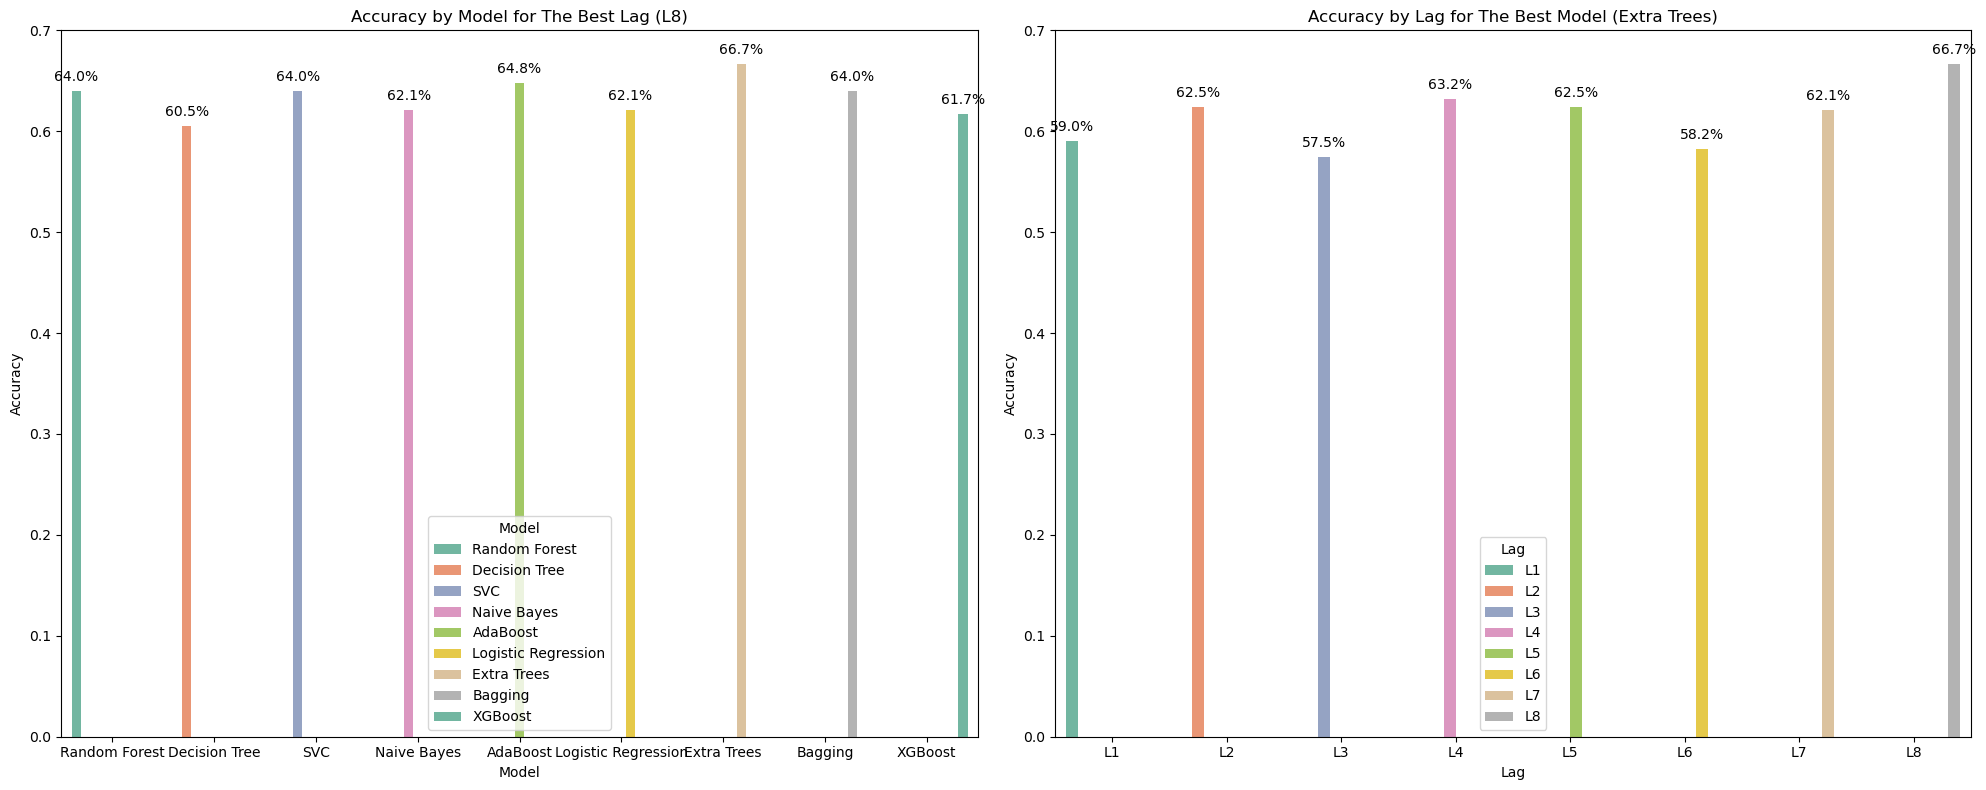

In [118]:
plot_best_lag_and_model_performance(metrics_df, "Accuracy")

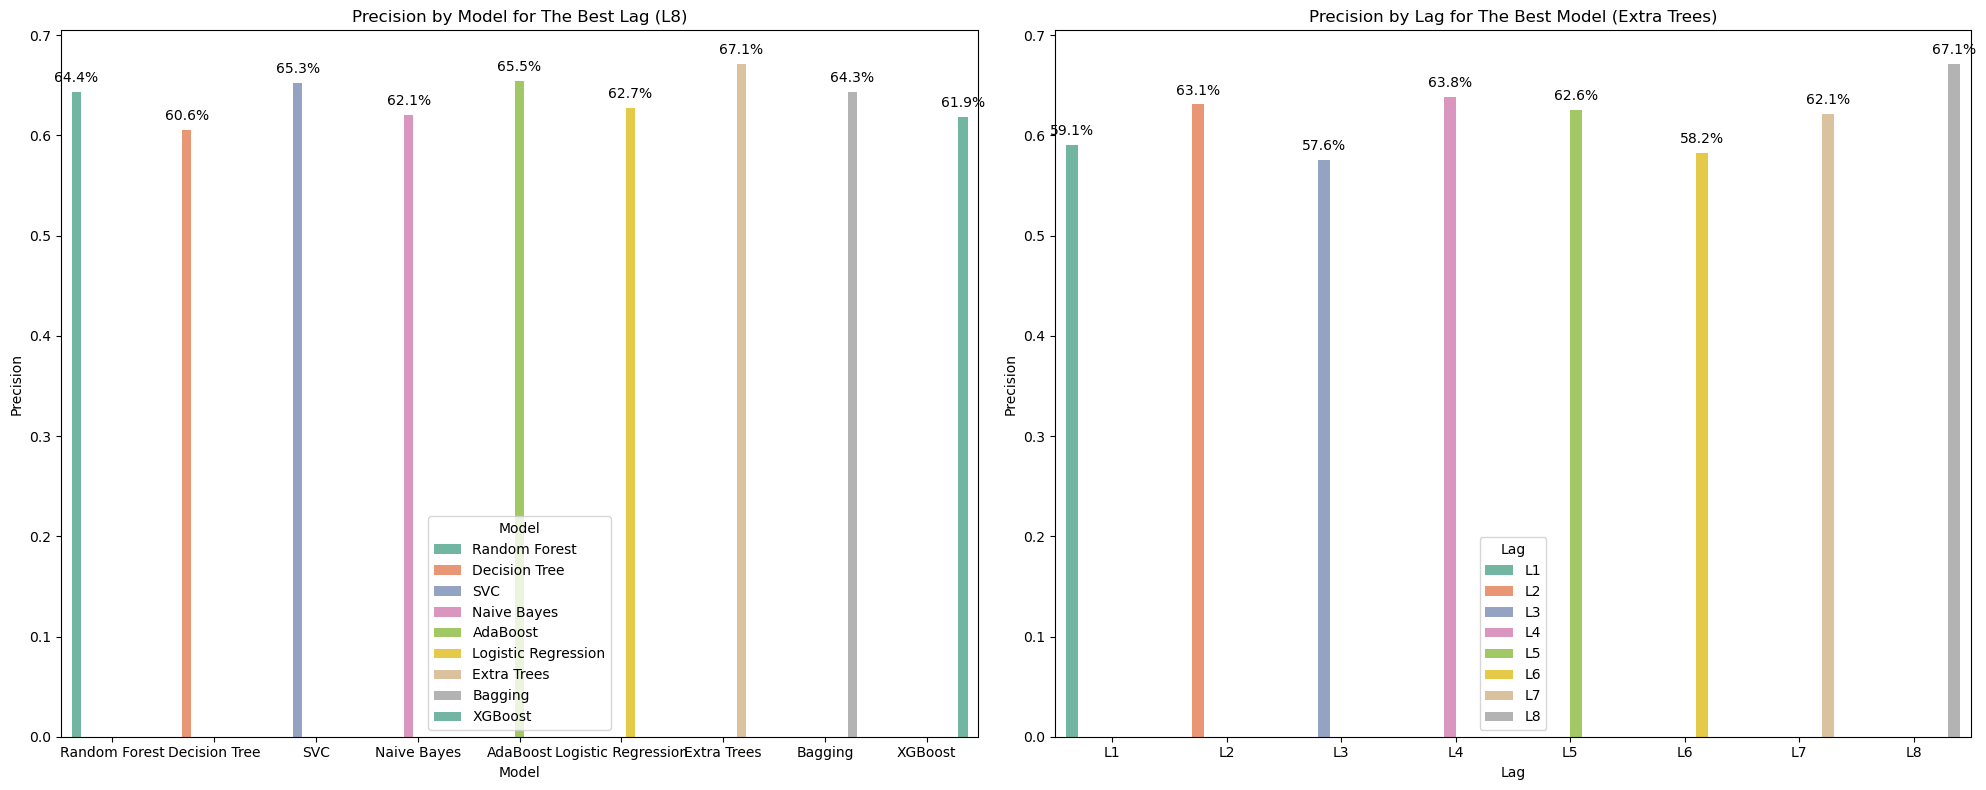

In [119]:
plot_best_lag_and_model_performance(metrics_df, "Precision")

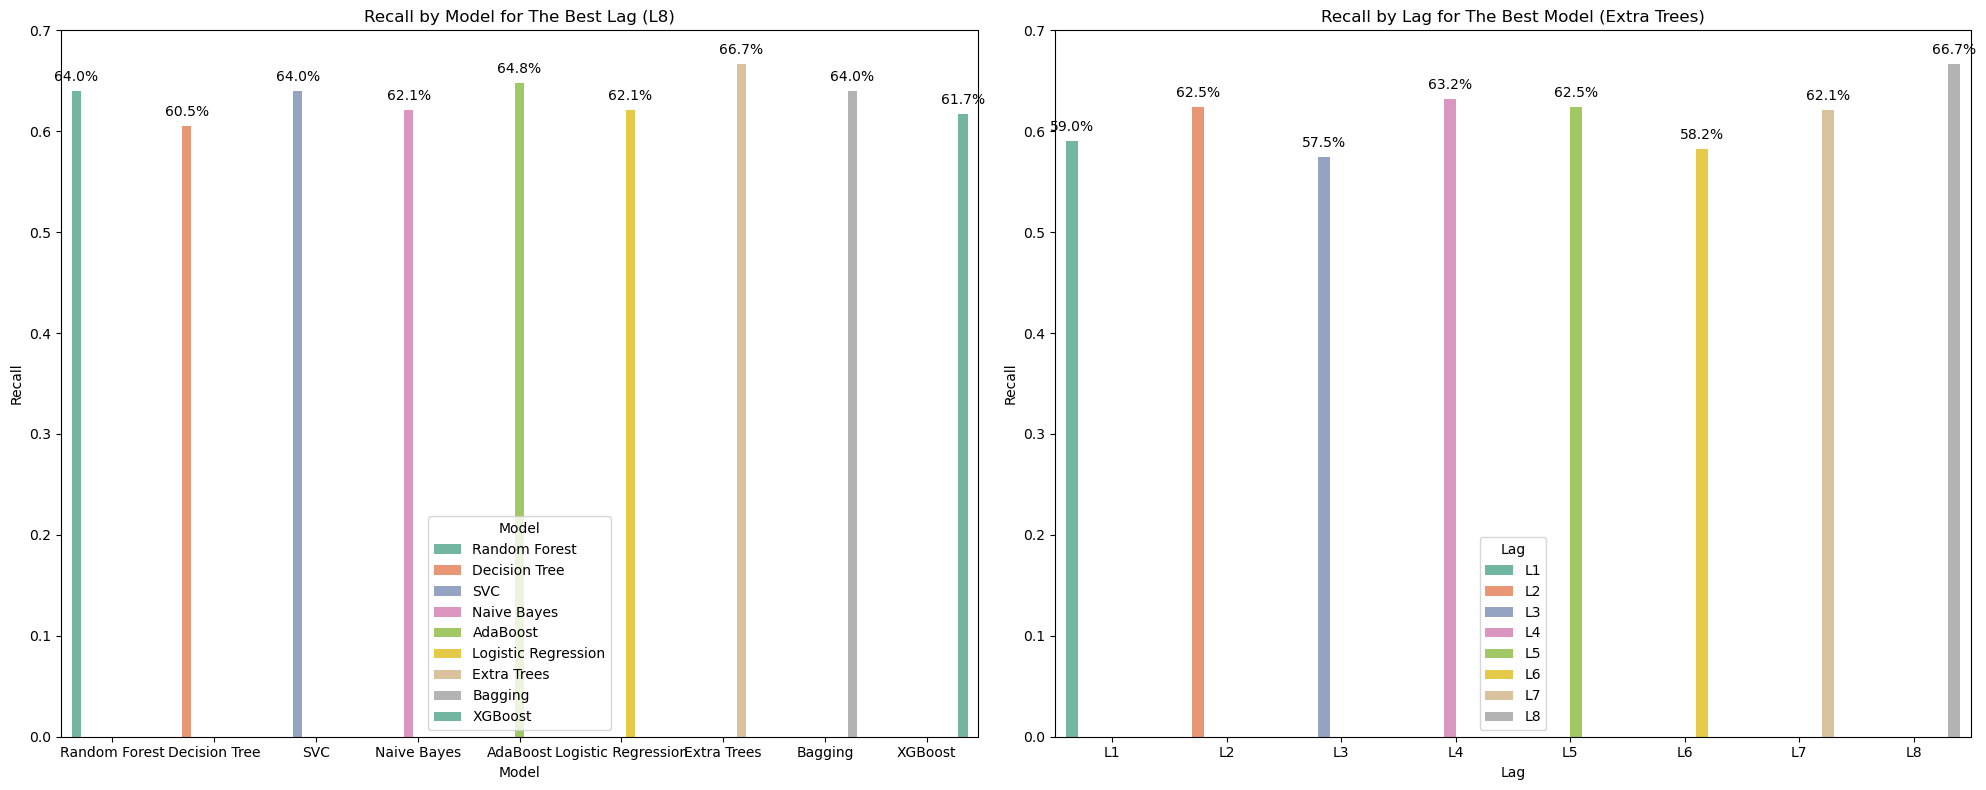

In [120]:
plot_best_lag_and_model_performance(metrics_df, "Recall")

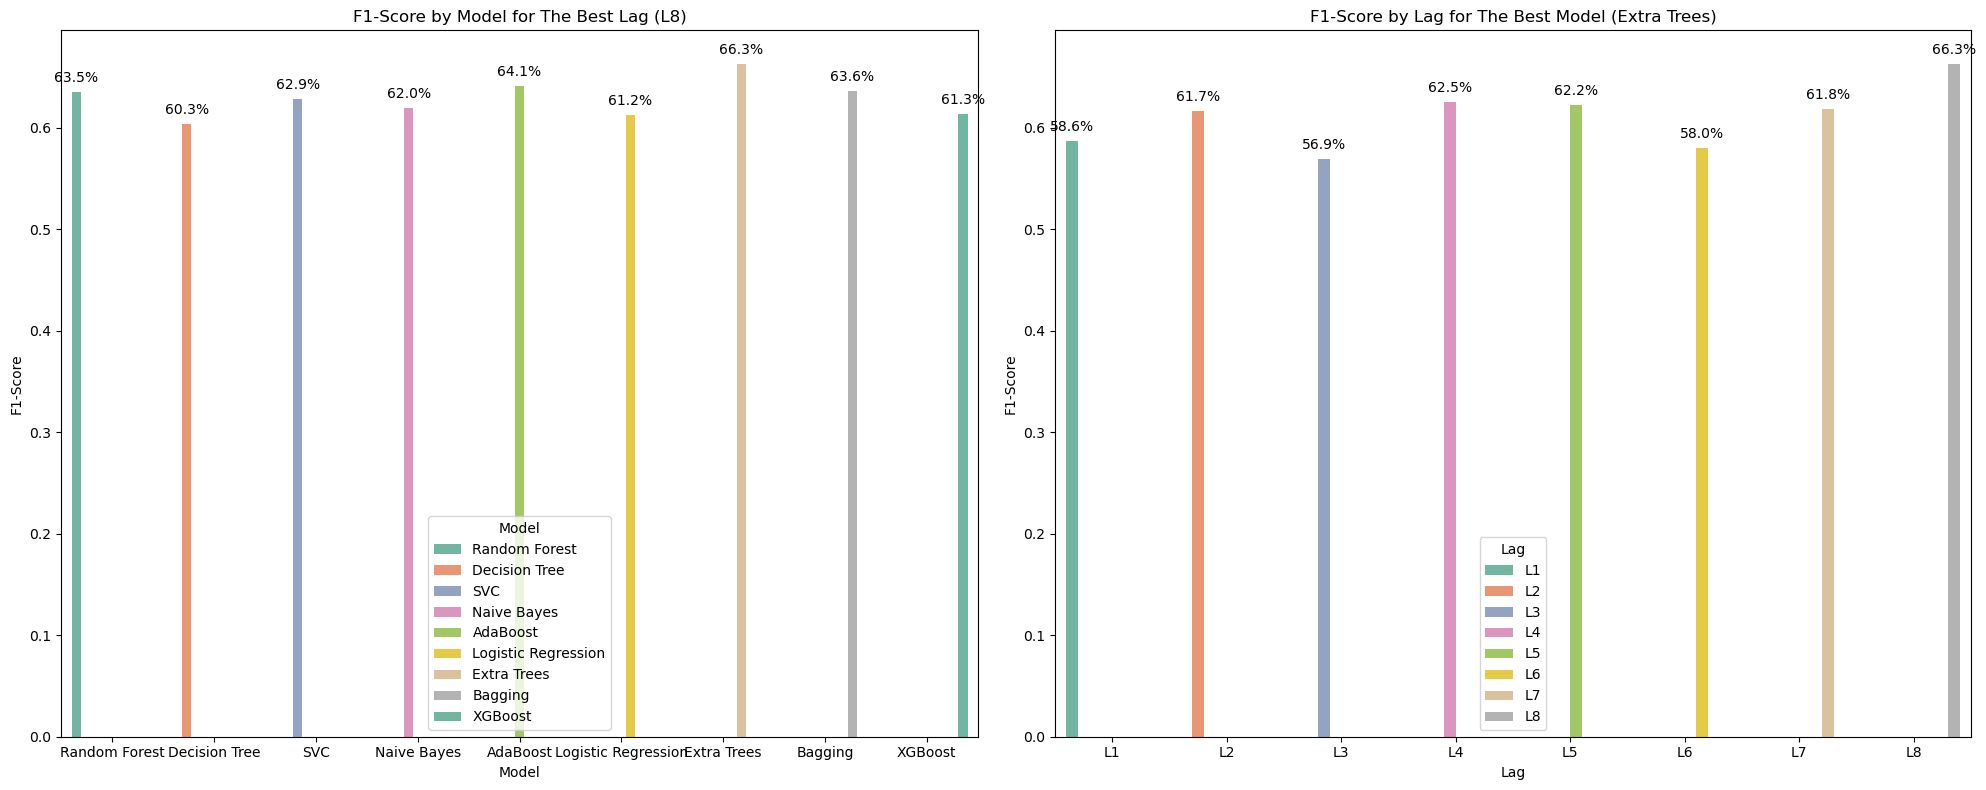

In [121]:
plot_best_lag_and_model_performance(metrics_df, "F1-Score")

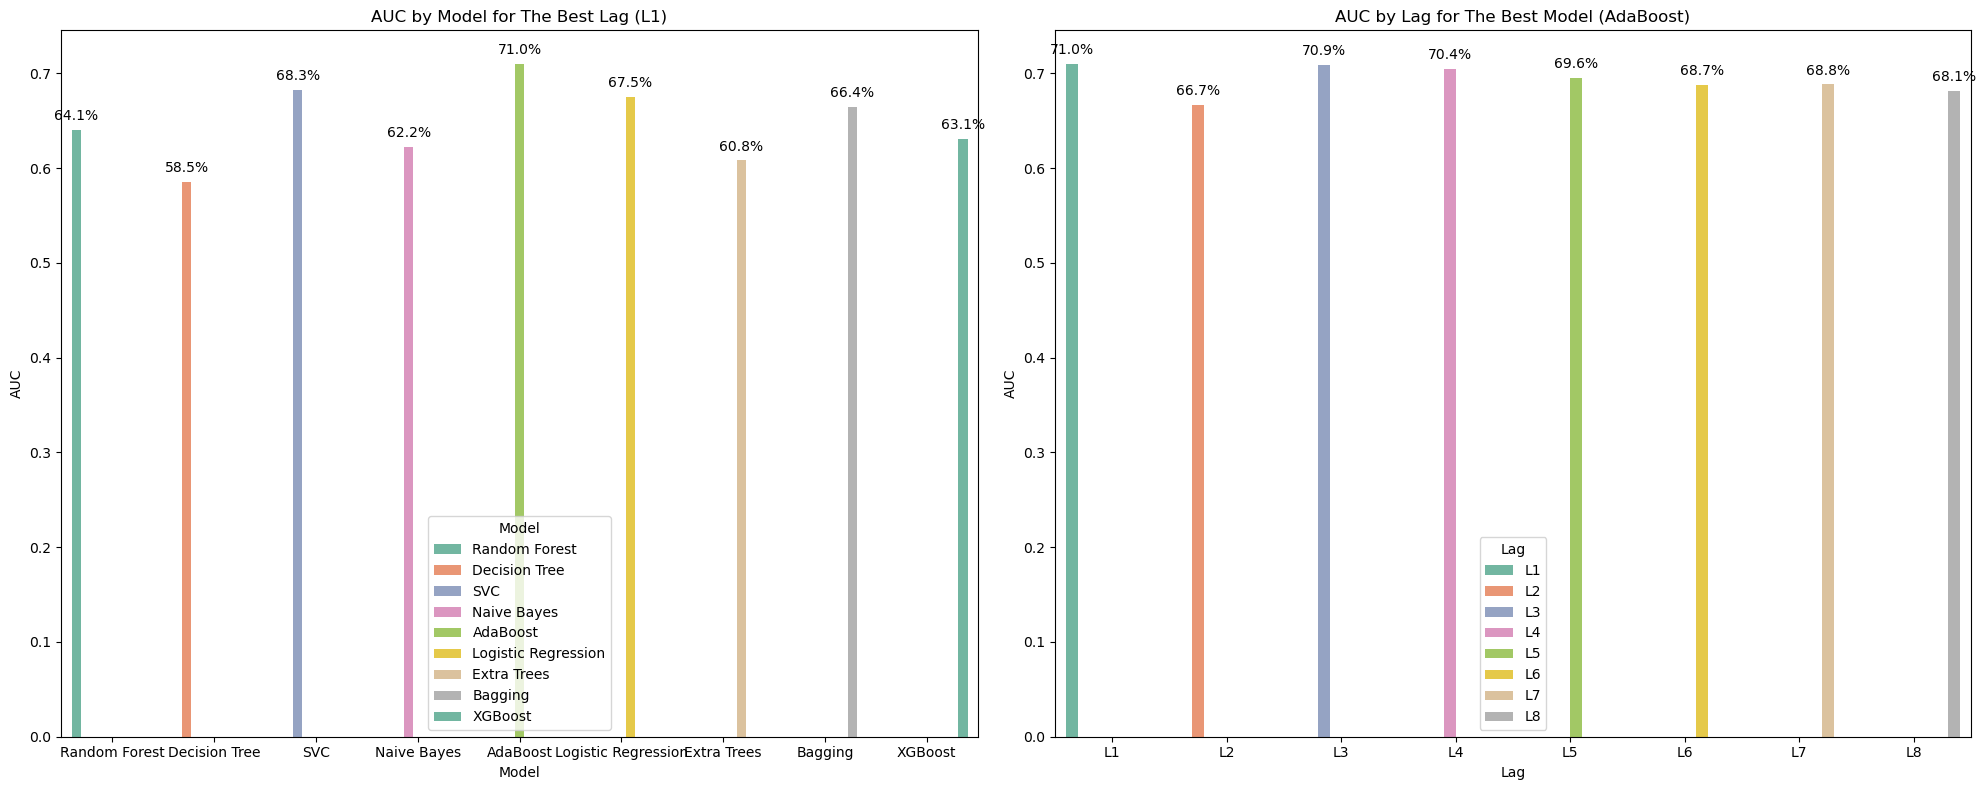

In [122]:
plot_best_lag_and_model_performance(metrics_df, "AUC")

In [128]:
# Identify the seven best models based on Accuracy
best_models_df = metrics_df.nlargest(5, 'Accuracy')
print("Top 10 models based on Accuracy:\n", best_models_df[['Model', 'Lag', 'Accuracy']])

Top 10 models based on Accuracy:
                   Model Lag  Accuracy
69          Extra Trees  L8  0.666667
31             AdaBoost  L4  0.651341
23  Logistic Regression  L3  0.647510
58             AdaBoost  L7  0.647510
67             AdaBoost  L8  0.647510


In [127]:
# Identify the seven best models based on Precision
best_models_df = metrics_df.nlargest(5, 'Precision')
print("Top 7 models based on Precision:\n", best_models_df[['Model', 'Lag', 'Precision']])

Top 7 models based on Precision:
                   Model Lag  Precision
69          Extra Trees  L8   0.671291
23  Logistic Regression  L3   0.658362
31             AdaBoost  L4   0.655292
2                   SVC  L1   0.654838
11                  SVC  L2   0.654838


In [72]:
# Identify the seven best models based on Recall
best_models_df = metrics_df.nlargest(7, 'Recall')
print("Top 7 models based on Recall:\n", best_models_df[['Model', 'Lag', 'Recall']])

Top 7 models based on Recall:
                   Model Lag    Recall
62          Extra Trees  L8  0.666667
32        Random Forest  L5  0.659004
54          Extra Trees  L7  0.655172
28             AdaBoost  L4  0.651341
46          Extra Trees  L6  0.651341
21  Logistic Regression  L3  0.647510
52             AdaBoost  L7  0.647510


In [129]:
# Identify the seven best models based on F1-Score
best_models_df = metrics_df.nlargest(5, 'F1-Score')
print("Top 7 models based on F1-Score:\n", best_models_df[['Model', 'Lag', 'F1-Score']])

Top 7 models based on F1-Score:
                   Model Lag  F1-Score
69          Extra Trees  L8  0.662692
31             AdaBoost  L4  0.647184
58             AdaBoost  L7  0.641648
67             AdaBoost  L8  0.640904
23  Logistic Regression  L3  0.638390


In [130]:
# Identify the seven best models based on AUC
best_models_df = metrics_df.nlargest(5, 'AUC')
print("Top 7 models based on AUC:\n", best_models_df[['Model', 'Lag', 'AUC']])

Top 7 models based on AUC:
        Model Lag       AUC
4   AdaBoost  L1  0.709866
22  AdaBoost  L3  0.708515
31  AdaBoost  L4  0.704489
65       SVC  L8  0.700964
40  AdaBoost  L5  0.695558


In [123]:
# Pivot the DataFrame to show performance metrics for each model across lags
performance_table = metrics_df.pivot_table(
    index=["Lag"], 
    columns=["Model"], 
    values=["Accuracy", "Precision", "Recall", "F1-Score", "AUC"]
)

# Display the table
print(performance_table)

            AUC                                                          \
Model  AdaBoost   Bagging Decision Tree Extra Trees Logistic Regression   
Lag                                                                       
L1     0.709866  0.664120      0.585057    0.608121            0.675167   
L2     0.666912  0.647403      0.565813    0.667764            0.661594   
L3     0.708515  0.626660      0.555265    0.628100            0.666353   
L4     0.704489  0.636209      0.615025    0.669585            0.655247   
L5     0.695558  0.670613      0.544394    0.638971            0.657304   
L6     0.687449  0.665149      0.627600    0.602744            0.657304   
L7     0.688212  0.685980      0.641350    0.636091            0.662122   
L8     0.681308  0.694118      0.596780    0.681279            0.662181   

                                                     Accuracy  ... Precision  \
Model Naive Bayes Random Forest       SVC   XGBoost  AdaBoost  ...   XGBoost   
Lag           

In [124]:
performance_table.to_csv("model_performance_across_lags.csv")

PermutationExplainer explainer: 262it [00:47,  4.36it/s]                                                                                                   


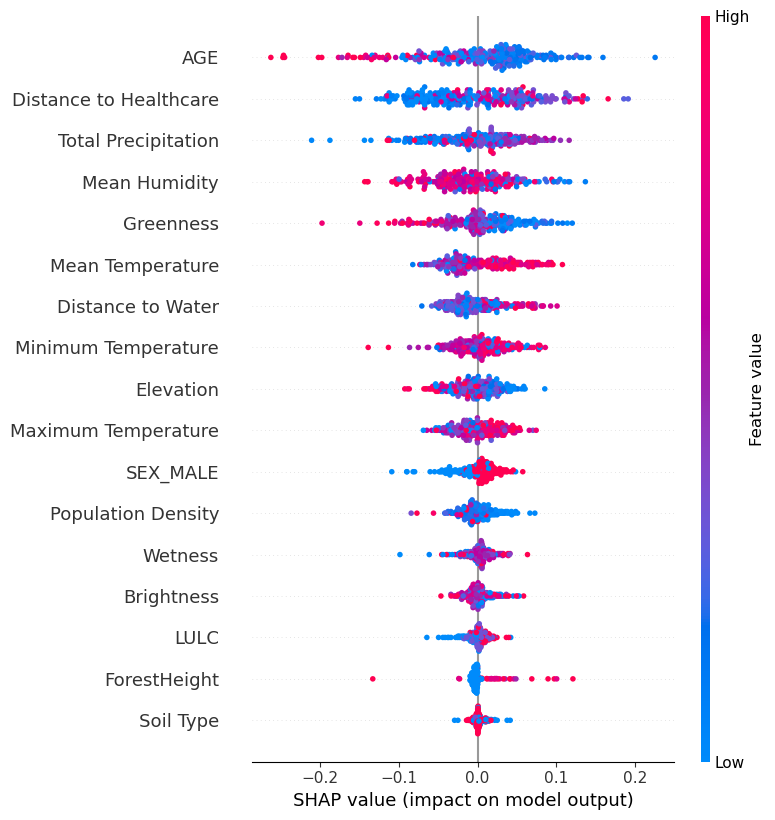

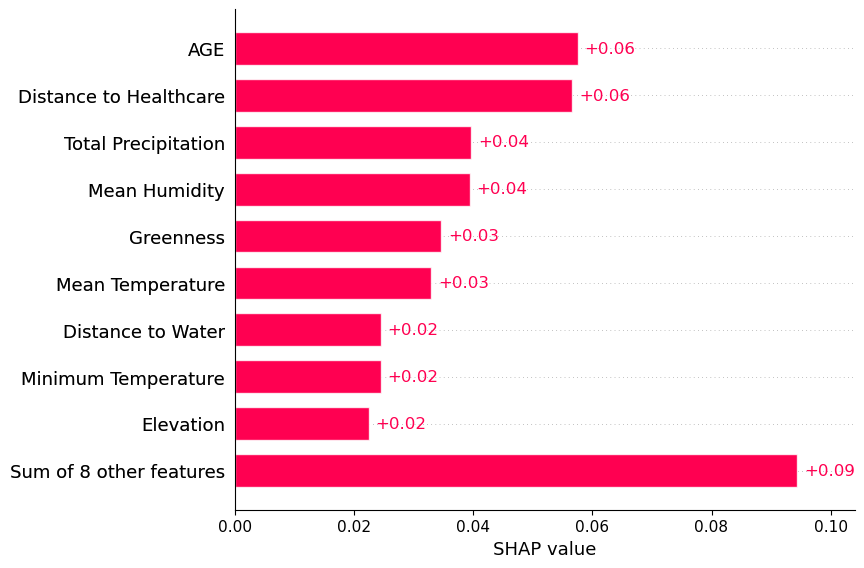

In [131]:
import numpy as np
import shap
import os

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Ensure Bagging model uses a fixed random state
bagging_model = models["Bagging"]
bagging_model.set_params(random_state=SEED)
bagging_model.fit(X_train_scaled, y_train) 

# Convert X_train and X_test to NumPy arrays (ensure correct dtype)
X_train = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_test_scaled, dtype=np.float32)

# Use SHAP Explainer with predict_proba (BaggingClassifier requires this)
explainer_bagging = shap.Explainer(bagging_model.predict_proba, X_train_scaled)

# Compute SHAP values on the test set
shap_values_bagging = explainer_bagging(X_test_scaled)

# Select SHAP values for the positive class (class 1)
shap_values_class_1 = shap_values_bagging.values[..., 1]  

# SHAP Summary Plot
shap.summary_plot(shap_values_class_1, X_test_scaled, feature_names=X_encoded.columns, title="Bagging Classifier SHAP (Class 1)")

# Compute mean absolute SHAP values for feature importance
shap_values_abs = np.abs(shap_values_class_1).mean(axis=0)
shap_values_exp = shap.Explanation(values=shap_values_abs, feature_names=X_encoded.columns)

# Generate SHAP Feature Importance Bar Plot
shap.plots.bar(shap_values_exp)


PermutationExplainer explainer: 262it [03:18,  1.25it/s]                                                                                                   


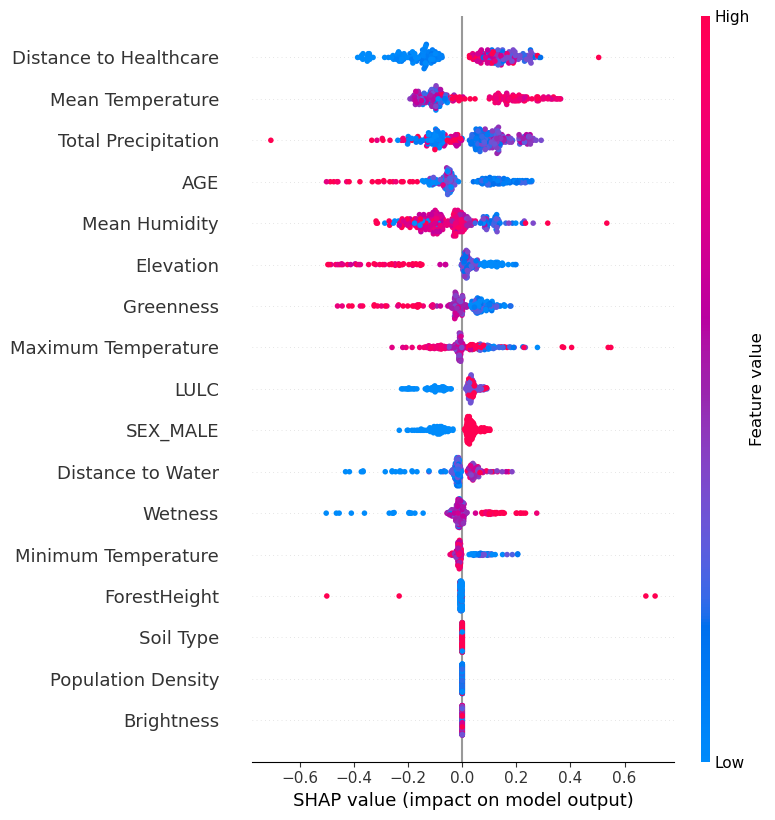

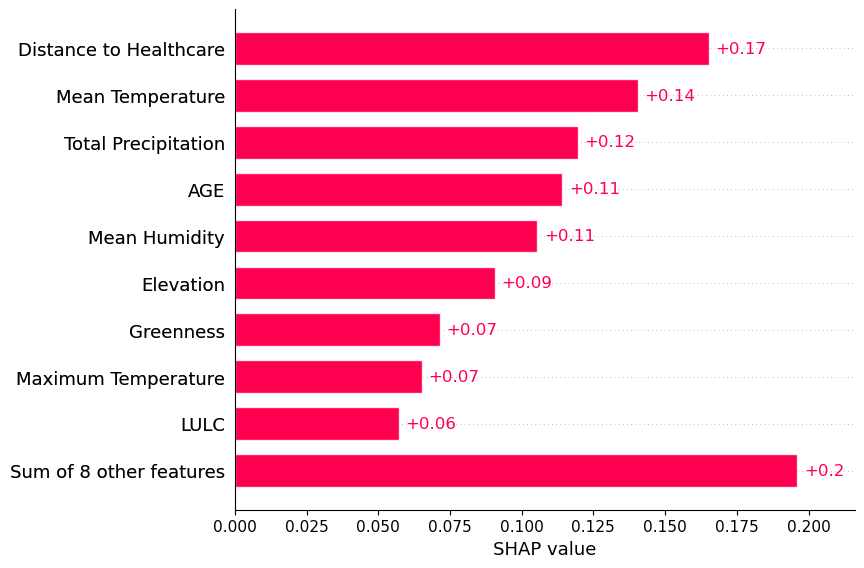

In [132]:

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Initialize AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=SEED)
adaboost_model.fit(X_train_scaled, y_train)  

# Convert X_train and X_test to NumPy arrays 
X_train = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_test_scaled, dtype=np.float32)

# Use SHAP's general Explainer
explainer_adaboost = shap.Explainer(adaboost_model.predict, X_train_scaled)

# Compute SHAP values on the test set
shap_values_adaboost = explainer_adaboost(X_test_scaled)

# SHAP Summary Plot
shap.summary_plot(shap_values_adaboost, X_test_scaled, feature_names=X_encoded.columns, title="AdaBoost SHAP Summary")

# Compute mean absolute SHAP values for feature importance
shap_values_abs = np.abs(shap_values_adaboost.values).mean(axis=0)
shap_values_exp = shap.Explanation(values=shap_values_abs, feature_names=X_encoded.columns)

# Generate SHAP Feature Importance Bar Plot
shap.plots.bar(shap_values_exp)


Original SHAP values shape: (261, 17, 2)
Final SHAP values shape: (261, 17)
X_test_scaled shape: (261, 17)


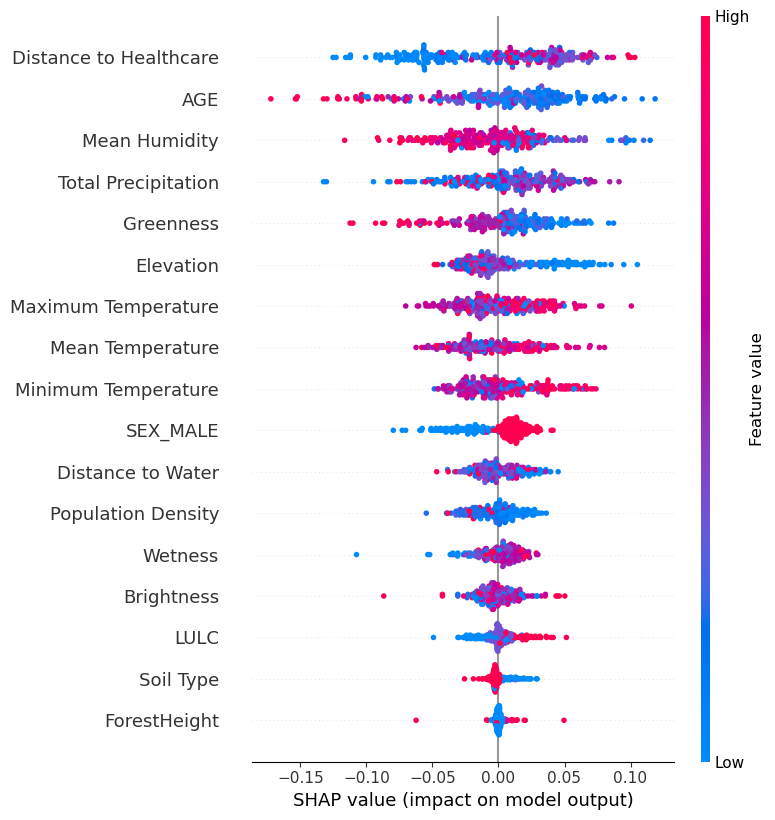

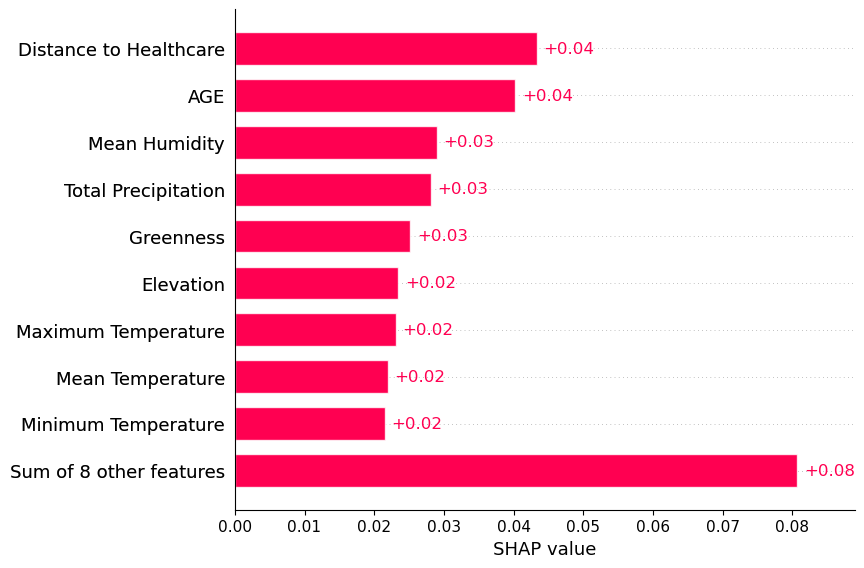

In [133]:
from sklearn.ensemble import RandomForestClassifier

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(X_train_scaled, y_train)

# Initialize SHAP using TreeExplainer
explainer_rf = shap.TreeExplainer(rf_model)

# Compute SHAP values using X_test_scaled
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# Convert to NumPy array for consistency
shap_values_rf = np.array(shap_values_rf)
print(f"Original SHAP values shape: {shap_values_rf.shape}")

# Handle Binary Classification (select SHAP values for Class 1)
if shap_values_rf.ndim == 3 and shap_values_rf.shape[2] == 2:
    shap_values_rf_class1 = shap_values_rf[..., 1]
else:
    raise ValueError(f"Unexpected SHAP shape: {shap_values_rf.shape}")

# Verify SHAP and X_test_scaled shape consistency
print(f"Final SHAP values shape: {shap_values_rf_class1.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

assert shap_values_rf_class1.shape == X_test_scaled.shape, \
    f"Shape mismatch: SHAP values {shap_values_rf_class1.shape} must match X_test_scaled {X_test_scaled.shape}."

# SHAP Summary Plot
shap.summary_plot(shap_values_rf_class1, X_test_scaled, feature_names=X_encoded.columns, title="Random Forest SHAP")

# Feature Importance Bar Plot
shap_values_rf_abs = np.abs(shap_values_rf_class1).mean(axis=0)
shap_values_rf_exp = shap.Explanation(values=shap_values_rf_abs, feature_names=X_encoded.columns)

shap.plots.bar(shap_values_rf_exp)



Original SHAP values shape: (261, 17, 2)
Final SHAP values shape: (261, 17)
X_test shape: (261, 17)


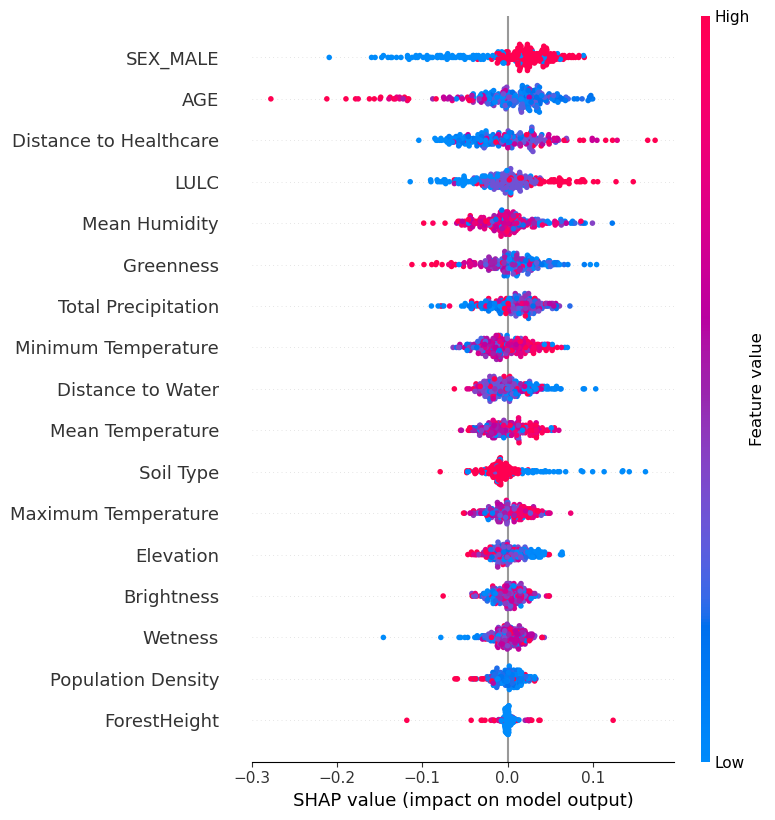

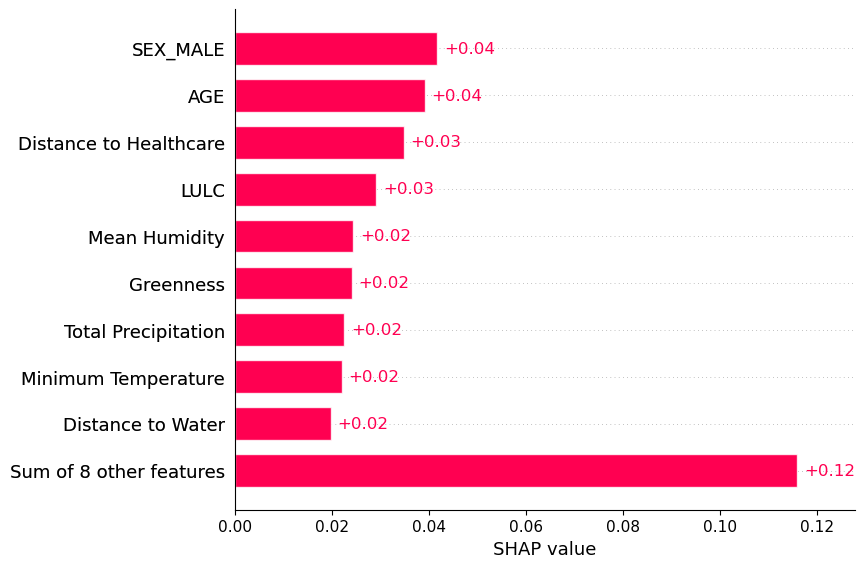

In [134]:
from sklearn.ensemble import ExtraTreesClassifier

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Train Extra Trees model
et_model = ExtraTreesClassifier(random_state=SEED)
et_model.fit(X_train_scaled, y_train)  

# Initialize SHAP using TreeExplainer
explainer_et = shap.TreeExplainer(et_model)

# Compute SHAP values using X_test
shap_values_et = explainer_et.shap_values(X_test_scaled)

# Convert to NumPy array for consistency
shap_values_et = np.array(shap_values_et)  
print(f"Original SHAP values shape: {shap_values_et.shape}")  

# Handle Binary Classification (select SHAP values for Class 1)
if shap_values_et.ndim == 3 and shap_values_et.shape[2] == 2:  
    shap_values_et_class1 = shap_values_et[..., 1]  
else:
    raise ValueError(f"Unexpected SHAP shape: {shap_values_et.shape}")

# Verify SHAP and X_test shape consistency
print(f"Final SHAP values shape: {shap_values_et_class1.shape}")
print(f"X_test shape: {X_test_scaled.shape}")

assert shap_values_et_class1.shape == X_test_scaled.shape, \
    f"Shape mismatch: SHAP values {shap_values_et_class1.shape} must match X_test {X_test_scaled.shape}."

# SHAP Summary Plot
shap.summary_plot(shap_values_et_class1, X_test_scaled, feature_names=X_encoded.columns, title="Extra Trees SHAP")

# Feature Importance Bar Plot
shap_values_et_abs = np.abs(shap_values_et_class1).mean(axis=0)  
shap_values_et_exp = shap.Explanation(values=shap_values_et_abs, feature_names=X_encoded.columns)

shap.plots.bar(shap_values_et_exp)


Original SHAP values shape: (261, 17)
X_test shape: (261, 17)


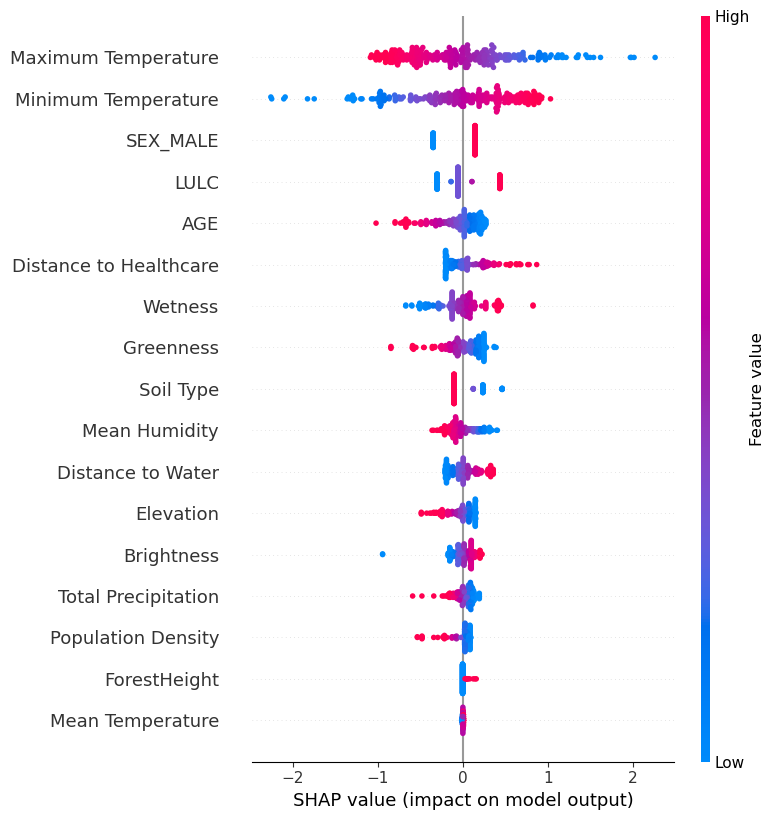

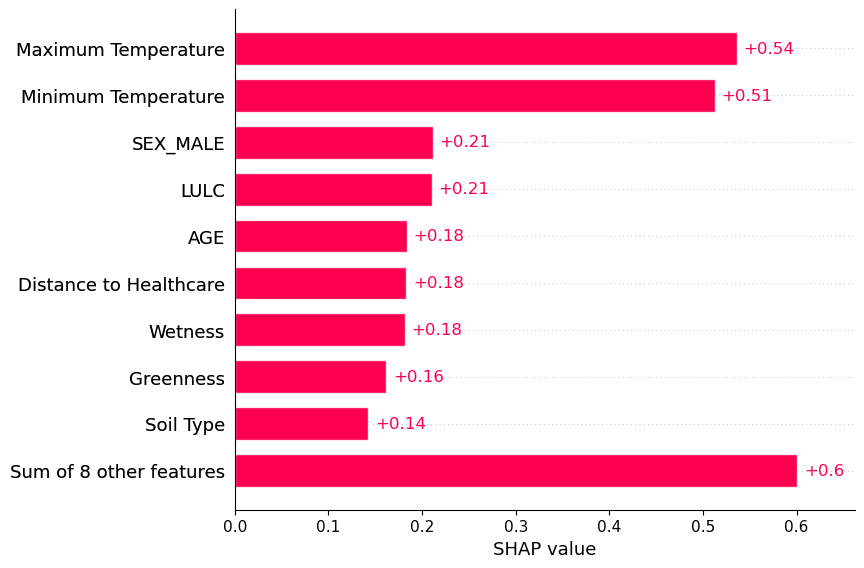

In [135]:

from sklearn.linear_model import LogisticRegression

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Train Logistic Regression model
logreg_model = LogisticRegression(random_state=SEED)
logreg_model.fit(X_train_scaled, y_train)

# Initialize SHAP using the general Explainer
explainer_logreg = shap.Explainer(logreg_model, X_train_scaled)

# Compute SHAP values on X_test
shap_values_logreg = explainer_logreg(X_test_scaled).values

# Convert to NumPy array
shap_values_logreg = np.array(shap_values_logreg)  
print(f"Original SHAP values shape: {shap_values_logreg.shape}")

# Verify Shape Matches X_test
print(f"X_test shape: {X_test_scaled.shape}")

assert shap_values_logreg.shape == X_test_scaled.shape, \
    f"Shape mismatch: SHAP values {shap_values_logreg.shape} must match X_test {X_test_scaled.shape}."

# SHAP Summary Plot
shap.summary_plot(shap_values_logreg, X_test_scaled, feature_names=X_encoded.columns, title="Logistic Regression SHAP")

# Feature Importance Bar Plot
shap_values_logreg_abs = np.abs(shap_values_logreg).mean(axis=0)  
shap_values_logreg_exp = shap.Explanation(values=shap_values_logreg_abs, feature_names=X_encoded.columns)

shap.plots.bar(shap_values_logreg_exp)


  0%|          | 0/261 [00:00<?, ?it/s]

Original SHAP values shape: (261, 17, 2)
Final SHAP values shape: (261, 17)
X_test shape: (261, 17)


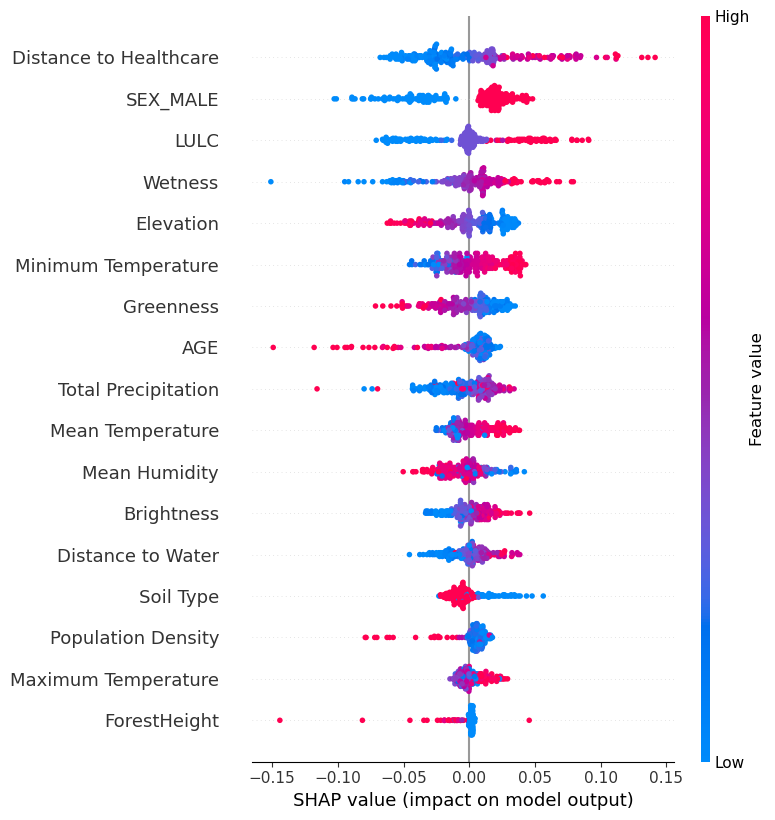

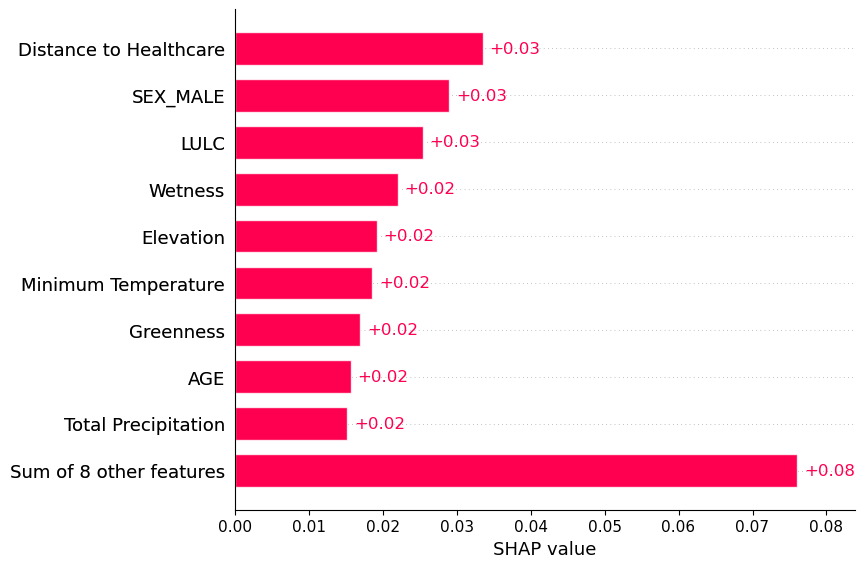

In [136]:
import multiprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Ensure X_train and X_test are NumPy arrays
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Support Vector Classifier (SVC) with probability enabled
svc_model = SVC(probability=True, random_state=RANDOM_SEED)
svc_model.fit(X_train, y_train)

# Enable parallel processing
num_cores = multiprocessing.cpu_count()

# Use a subset of training data as background for efficiency
background = shap.sample(X_train, 100)  

# Initialize SHAP Kernel Explainer
explainer_svc = shap.KernelExplainer(svc_model.predict_proba, background, n_jobs=num_cores)

# Compute SHAP values for the test set
shap_values_svc = explainer_svc.shap_values(X_test)

# Convert SHAP values to NumPy array
shap_values_svc = np.array(shap_values_svc)
print(f"Original SHAP values shape: {shap_values_svc.shape}")

# Handle SHAP output for binary classification
if shap_values_svc.ndim == 3 and shap_values_svc.shape[2] == 2:  
    shap_values_svc_class1 = shap_values_svc[..., 1]  # Select SHAP values for Class 1
else:
    raise ValueError(f"Unexpected SHAP shape: {shap_values_svc.shape}")

# Verify shape matches X_test
print(f"Final SHAP values shape: {shap_values_svc_class1.shape}")
print(f"X_test shape: {X_test.shape}")

assert shap_values_svc_class1.shape == X_test.shape, \
    f"Shape mismatch: SHAP values {shap_values_svc_class1.shape} must match X_test {X_test.shape}."

# SHAP Summary Plot
shap.summary_plot(shap_values_svc_class1, X_test, feature_names=X_encoded.columns, title="SVC SHAP (Kernel Explainer)")

# Feature Importance Bar Plot
shap_values_svc_abs = np.abs(shap_values_svc_class1).mean(axis=0)  # Mean absolute SHAP values per feature
shap_values_svc_exp = shap.Explanation(values=shap_values_svc_abs, feature_names=X_encoded.columns)

shap.plots.bar(shap_values_svc_exp)


PermutationExplainer explainer: 262it [00:54,  3.84it/s]                                                                                                   


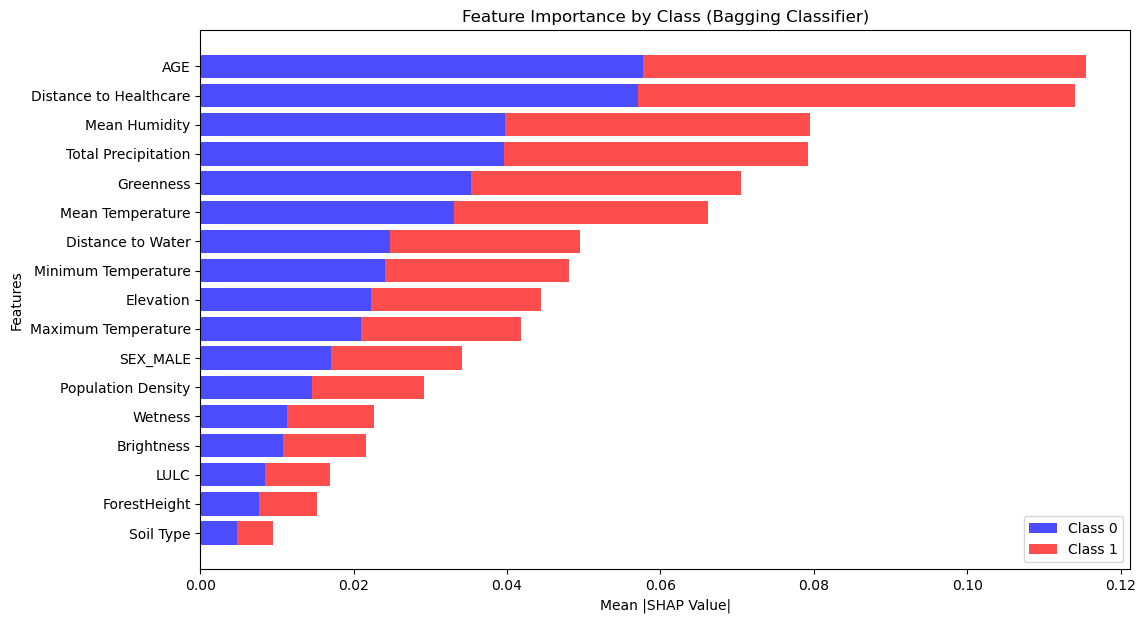

In [137]:

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Train Bagging model
bagging_model = models["Bagging"].fit(X_train_scaled, y_train)

# Initialize SHAP explainer
explainer_bagging = shap.Explainer(bagging_model.predict_proba, X_train_scaled)

# Compute SHAP values
shap_values_bagging = explainer_bagging(X_test_scaled)

# Separate SHAP values by class
shap_values_class_0 = shap_values_bagging.values[:, :, 0]  # Class 0
shap_values_class_1 = shap_values_bagging.values[:, :, 1]  # Class 1

# Compute mean absolute SHAP values for each class
mean_shap_class_0 = np.abs(shap_values_class_0).mean(axis=0)
mean_shap_class_1 = np.abs(shap_values_class_1).mean(axis=0)

# Compute total importance (sum of both class SHAP values)
total_shap_importance = mean_shap_class_0 + mean_shap_class_1

# Sort features by total importance (descending order)
sorted_indices = np.argsort(total_shap_importance)[::-1]  
sorted_feature_names = X_encoded.columns[sorted_indices]
sorted_shap_class_0 = mean_shap_class_0[sorted_indices]
sorted_shap_class_1 = mean_shap_class_1[sorted_indices]

# Create a grouped bar plot with sorted features
x = np.arange(len(sorted_feature_names))

plt.figure(figsize=(12, 7))
plt.barh(x, sorted_shap_class_0, color='blue', alpha=0.7, label='Class 0')
plt.barh(x, sorted_shap_class_1, color='red', alpha=0.7, left=sorted_shap_class_0, label='Class 1')

plt.yticks(x, sorted_feature_names)
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Features")
plt.title("Feature Importance by Class (Bagging Classifier)")
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()




PermutationExplainer explainer: 262it [03:40,  1.13it/s]                                                                                                   


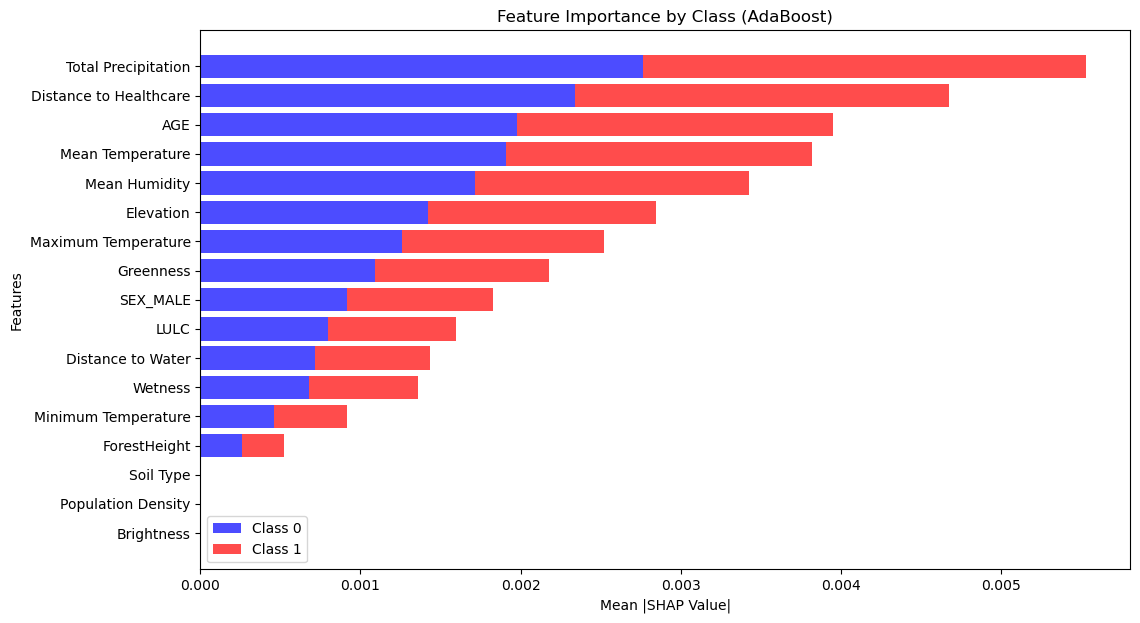

In [138]:
import numpy as np
import os
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Train AdaBoost model
adaboost_model = AdaBoostClassifier(random_state=SEED)
adaboost_model.fit(X_train_scaled, y_train)  

# Convert X_train and X_test to NumPy arrays 
X_train = np.array(X_train_scaled, dtype=np.float32)
X_test = np.array(X_test_scaled, dtype=np.float32)

# Use SHAP's general Explainer
explainer_adaboost = shap.Explainer(adaboost_model.predict_proba, X_train_scaled)

# Compute SHAP values on the test set
shap_values_adaboost = explainer_adaboost(X_test_scaled)

# Separate SHAP values by class
shap_values_class_0 = shap_values_adaboost.values[:, :, 0]  # Class 0
shap_values_class_1 = shap_values_adaboost.values[:, :, 1]  # Class 1

# Compute mean absolute SHAP values for each class
mean_shap_class_0 = np.abs(shap_values_class_0).mean(axis=0)
mean_shap_class_1 = np.abs(shap_values_class_1).mean(axis=0)

# Total feature importance (sum across classes)
total_shap_values = mean_shap_class_0 + mean_shap_class_1

# Sort features by total SHAP importance
sorted_indices = np.argsort(total_shap_values)[::-1]  # Descending order
sorted_features = X_encoded.columns[sorted_indices]
mean_shap_class_0 = mean_shap_class_0[sorted_indices]
mean_shap_class_1 = mean_shap_class_1[sorted_indices]

# Create a grouped bar plot (sorted)
x = np.arange(len(sorted_features))

plt.figure(figsize=(12, 7))
plt.barh(x, mean_shap_class_0, color='blue', alpha=0.7, label='Class 0')
plt.barh(x, mean_shap_class_1, color='red', alpha=0.7, left=mean_shap_class_0, label='Class 1')

plt.yticks(x, sorted_features)
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Features")
plt.title("Feature Importance by Class (AdaBoost)")
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()




In [ ]:

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(X_train_scaled, y_train)

# Initialize SHAP using TreeExplainer
explainer_rf = shap.TreeExplainer(rf_model)

# Compute SHAP values using X_test
shap_values_rf = explainer_rf.shap_values(X_test_scaled)

# Convert to NumPy array for consistency
shap_values_rf = np.array(shap_values_rf)  
print(f"Original SHAP values shape: {shap_values_rf.shape}")  

# Adjust SHAP extraction to match shape (261, 17, 2)
if shap_values_rf.ndim == 3 and shap_values_rf.shape[2] == 2:  
    shap_values_rf_class_0 = shap_values_rf[:, :, 0]  # SHAP values for Class 0
    shap_values_rf_class_1 = shap_values_rf[:, :, 1]  # SHAP values for Class 1
else:
    raise ValueError(f"Unexpected SHAP shape: {shap_values_rf.shape}")

# Verify SHAP and X_test shape consistency
print(f"SHAP values shape (Class 0): {shap_values_rf_class_0.shape}")
print(f"SHAP values shape (Class 1): {shap_values_rf_class_1.shape}")
print(f"X_test shape: {X_test.shape}")

assert shap_values_rf_class_0.shape == X_test_scaled.shape, \
    f"Shape mismatch: SHAP values {shap_values_rf_class_0.shape} must match X_test {X_test_scaled.shape}."

assert shap_values_rf_class_1.shape == X_test_scaled.shape, \
    f"Shape mismatch: SHAP values {shap_values_rf_class_1.shape} must match X_test {X_test_scaled.shape}."

# Compute mean absolute SHAP values for feature importance (per class)
mean_shap_class_0 = np.abs(shap_values_rf_class_0).mean(axis=0)
mean_shap_class_1 = np.abs(shap_values_rf_class_1).mean(axis=0)

# Total feature importance (sum across classes)
total_shap_values = mean_shap_class_0 + mean_shap_class_1

# Sort features by total SHAP importance
sorted_indices = np.argsort(total_shap_values)[::-1]  # Descending order
sorted_features = X_encoded.columns[sorted_indices]
mean_shap_class_0 = mean_shap_class_0[sorted_indices]
mean_shap_class_1 = mean_shap_class_1[sorted_indices]

# Create a grouped bar plot (sorted)
x = np.arange(len(sorted_features))

plt.figure(figsize=(12, 7))
plt.barh(x, mean_shap_class_0, color='blue', alpha=0.7, label='Class 0')
plt.barh(x, mean_shap_class_1, color='red', alpha=0.7, left=mean_shap_class_0, label='Class 1')

plt.yticks(x, sorted_features)
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Features")
plt.title("Feature Importance by Class (Random Forest)")
plt.legend()
plt.gca().invert_yaxis()  
plt.show()


SHAP values shape (Class 0): (261, 17)
SHAP values shape (Class 1): (261, 17)
X_test shape: (261, 17)


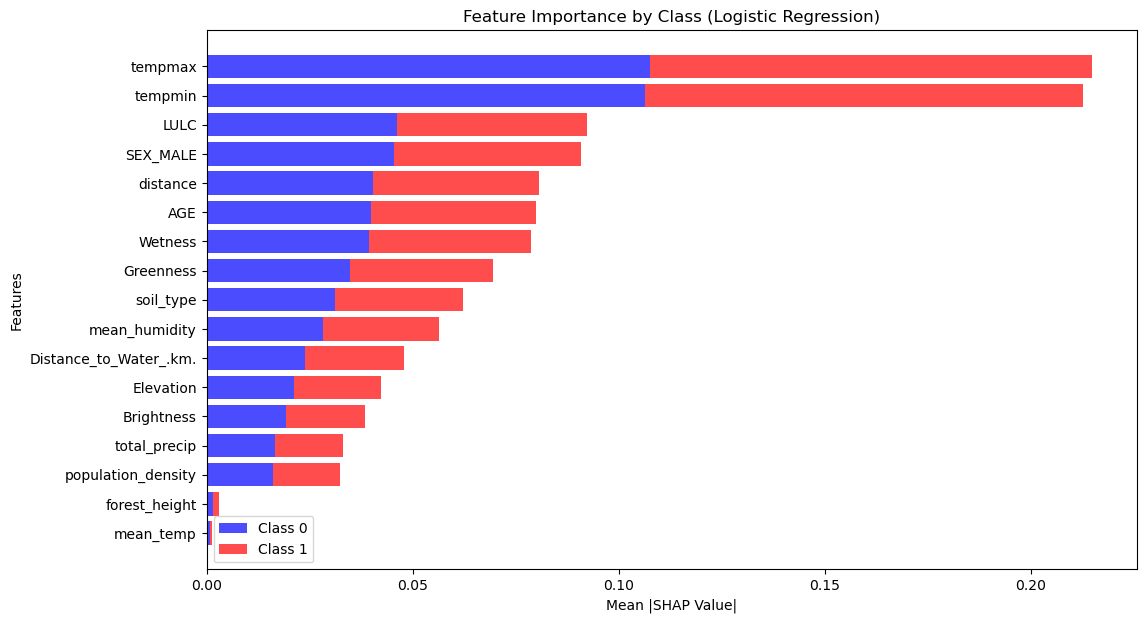

In [69]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Train Logistic Regression model
logreg_model = LogisticRegression(random_state=SEED)
logreg_model.fit(X_train_scaled, y_train)

# Use SHAP's Explainer with predict_proba to get SHAP values for both classes
explainer_logreg = shap.Explainer(logreg_model.predict_proba, X_train_scaled)

# Compute SHAP values on X_test
shap_values_logreg = explainer_logreg(X_test_scaled)

# Extract separate SHAP values for Class 0 and Class 1
shap_values_class_0 = shap_values_logreg.values[:, :, 0]  # Class 0
shap_values_class_1 = shap_values_logreg.values[:, :, 1]  # Class 1

# Verify Shape Matches X_test
print(f"SHAP values shape (Class 0): {shap_values_class_0.shape}")
print(f"SHAP values shape (Class 1): {shap_values_class_1.shape}")
print(f"X_test shape: {X_test.shape}")

assert shap_values_class_0.shape == X_test_scaled.shape, \
    f"Shape mismatch: SHAP values {shap_values_class_0.shape} must match X_test {X_test_scaled.shape}."

assert shap_values_class_1.shape == X_test_scaled.shape, \
    f"Shape mismatch: SHAP values {shap_values_class_1.shape} must match X_test {X_test_scaled.shape}."

# Compute mean absolute SHAP values for feature importance (per class)
mean_shap_class_0 = np.abs(shap_values_class_0).mean(axis=0)
mean_shap_class_1 = np.abs(shap_values_class_1).mean(axis=0)

# Total feature importance (sum across classes)
total_shap_values = mean_shap_class_0 + mean_shap_class_1

# Sort features by total SHAP importance
sorted_indices = np.argsort(total_shap_values)[::-1]  # Descending order
sorted_features = X_encoded.columns[sorted_indices]
mean_shap_class_0 = mean_shap_class_0[sorted_indices]
mean_shap_class_1 = mean_shap_class_1[sorted_indices]

# Create a grouped bar plot (sorted)
x = np.arange(len(sorted_features))

plt.figure(figsize=(12, 7))
plt.barh(x, mean_shap_class_0, color='blue', alpha=0.7, label='Class 0')
plt.barh(x, mean_shap_class_1, color='red', alpha=0.7, left=mean_shap_class_0, label='Class 1')

plt.yticks(x, sorted_features)
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Features")
plt.title("Feature Importance by Class (Logistic Regression)")
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


Original SHAP values shape: (261, 17, 2)
SHAP values shape (Class 0): (261, 17)
SHAP values shape (Class 1): (261, 17)
X_test shape: (261, 17)


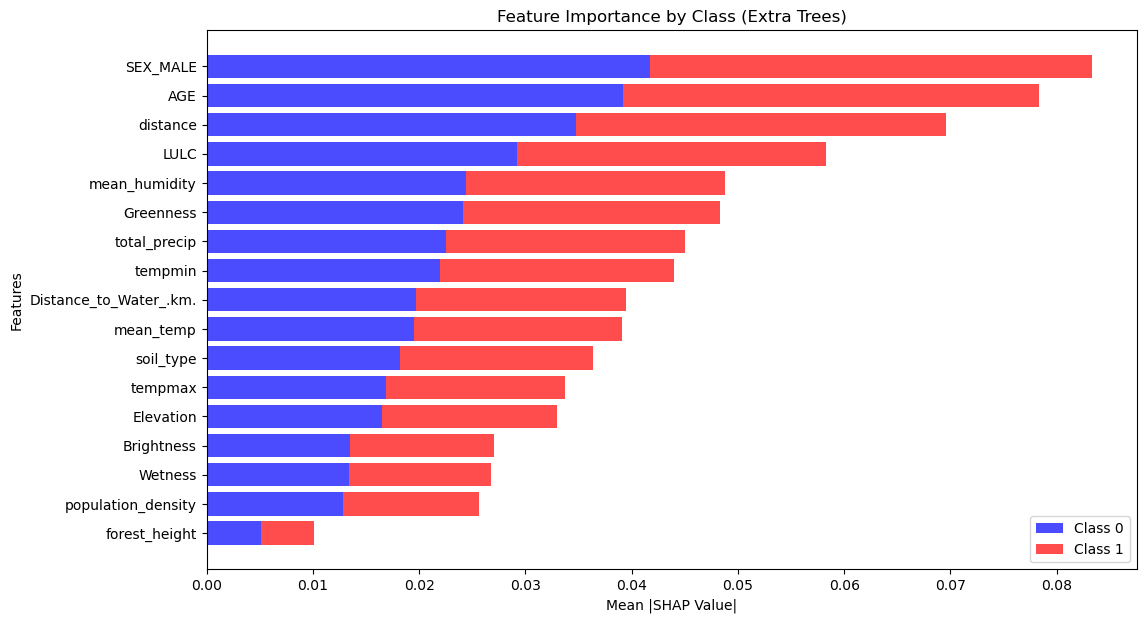

In [70]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Train Extra Trees model
et_model = ExtraTreesClassifier(random_state=SEED)
et_model.fit(X_train_scaled, y_train)  

# Initialize SHAP using TreeExplainer
explainer_et = shap.TreeExplainer(et_model)

# Compute SHAP values using X_test
shap_values_et = explainer_et.shap_values(X_test_scaled)

# Convert to NumPy array for consistency
shap_values_et = np.array(shap_values_et)  
print(f"Original SHAP values shape: {shap_values_et.shape}")  

# Handle Binary Classification (extract SHAP values per class)
if shap_values_et.ndim == 3 and shap_values_et.shape[2] == 2:  
    shap_values_et_class_0 = shap_values_et[:, :, 0]  # SHAP values for Class 0
    shap_values_et_class_1 = shap_values_et[:, :, 1]  # SHAP values for Class 1
else:
    raise ValueError(f"Unexpected SHAP shape: {shap_values_et.shape}")

# Verify Shape Matches X_test
print(f"SHAP values shape (Class 0): {shap_values_et_class_0.shape}")
print(f"SHAP values shape (Class 1): {shap_values_et_class_1.shape}")
print(f"X_test shape: {X_test.shape}")

assert shap_values_et_class_0.shape == X_test_scaled.shape, \
    f"Shape mismatch: SHAP values {shap_values_et_class_0.shape} must match X_test {X_test_scaled.shape}."

assert shap_values_et_class_1.shape == X_test_scaled.shape, \
    f"Shape mismatch: SHAP values {shap_values_et_class_1.shape} must match X_test {X_test_scaled.shape}."

# Compute mean absolute SHAP values for feature importance (per class)
mean_shap_class_0 = np.abs(shap_values_et_class_0).mean(axis=0)
mean_shap_class_1 = np.abs(shap_values_et_class_1).mean(axis=0)

# Total feature importance (sum across classes)
total_shap_values = mean_shap_class_0 + mean_shap_class_1

# Sort features by total SHAP importance
sorted_indices = np.argsort(total_shap_values)[::-1]  # Descending order
sorted_features = X_encoded.columns[sorted_indices]
mean_shap_class_0 = mean_shap_class_0[sorted_indices]
mean_shap_class_1 = mean_shap_class_1[sorted_indices]

# Create a grouped bar plot (sorted)
x = np.arange(len(sorted_features))

plt.figure(figsize=(12, 7))
plt.barh(x, mean_shap_class_0, color='blue', alpha=0.7, label='Class 0')
plt.barh(x, mean_shap_class_1, color='red', alpha=0.7, left=mean_shap_class_0, label='Class 1')

plt.yticks(x, sorted_features)
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Features")
plt.title("Feature Importance by Class (Extra Trees)")
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()
